In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps' if torch.backends.mps.is_available() else device)
print(f"Using device: {device}")

Using device: cpu


## 2. Lotka-volterra

In [2]:
class PINN(nn.Module):
    """
    Physics-Informed Neural Network for solving PDEs.

    The network takes (x, t) as input and outputs u(x, t).
    """

    def __init__(self, layers):
        super(PINN, self).__init__()

        self.layers = nn.ModuleList()

        # Build the network
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

        # Initialize weights using Xavier initialization
        self.init_weights()

    def init_weights(self):
        for layer in self.layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, t):
        inputs = t
        # Pass through hidden layers with tanh activation
        for i in range(len(self.layers) - 1):
            inputs = torch.tanh(self.layers[i](inputs))

        # Output layer (no activation)
        output = self.layers[-1](inputs)

        return output

In [3]:
def compute_pde_residual(model, t, alpha, beta, gamma, delta):
    """
    Lotka-Volterra equations residual computation.

    Standard form:
        dx/dt = alpha*x - beta*x*y   (prey: growth - predation)
        dy/dt = delta*x*y - gamma*y  (predator: growth from eating - death)
    """
    t.requires_grad = True

    # Forward pass
    xy = model(t)
    x = xy[:, 0:1]  # Keep dimensions for proper broadcasting
    y = xy[:, 1:2]

    # Compute gradients
    x_t = torch.autograd.grad(
        x, t, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True
    )[0]

    y_t = torch.autograd.grad(
        y, t, grad_outputs=torch.ones_like(y), create_graph=True, retain_graph=True
    )[0]

    # Residuals for the system of ODEs
    residual_x = x_t - (alpha * x - beta * x * y)
    residual_y = y_t - (delta * x * y - gamma * y)

    return residual_x, residual_y


def initial_condition(device=device):
    # Initial conditions at t=0 for (x=prey, y=predator)
    # Starting with x=40, y=9 (away from equilibrium to see oscillations)
    return torch.tensor([[40.0, 9.0]], device=device)

In [4]:
def train_pinn(
    model,
    n_epochs=5000,
    lr=0.001,
    n_collocation=1000,
    alpha=0.01,
    beta=0.01,
    gamma=0.01,
    delta=0.01,
    tMax=50,
    ic_weight=10.0,
    use_causal=True,
):
    """
    Train the Physics-Informed Neural Network.

    Args:
        model: PINN model
        n_epochs: Number of training epochs
        lr: Learning rate
        n_collocation: Number of collocation points for ODE
        alpha, beta, gamma, delta: Lotka-Volterra parameters
        tMax: Maximum time for sampling collocation points
        ic_weight: Weight for initial condition loss
        use_causal: Whether to use causal weighting (prioritize early times)
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Use CosineAnnealingWarmRestarts - LR recovers periodically instead of going to zero
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=1000,  # Restart every 1000 epochs
        T_mult=2,  # Double the period after each restart
        eta_min=1e-6,  # Minimum LR
    )

    losses = []

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Generate collocation points for ODE (random points in [0, tMax])
        t_pde = (tMax * torch.rand(n_collocation, 1)).to(device)

        # Initial condition at t = 0
        u_ic = initial_condition()  # (1, 2) on device

        # 1. PDE residual loss with causal weighting
        residual_x, residual_y = compute_pde_residual(
            model, t_pde, alpha, beta, gamma, delta
        )

        if use_causal:
            # Causal weighting: earlier times have higher weight
            # This helps because solution at later times depends on earlier times
            causal_weights = torch.exp(-t_pde / tMax * 2.0)  # Exponential decay
            loss_pde = torch.mean(causal_weights * residual_x**2) + torch.mean(
                causal_weights * residual_y**2
            )
        else:
            loss_pde = torch.mean(residual_x**2) + torch.mean(residual_y**2)

        # 2. Initial condition loss (weighted more heavily)
        u_pred_ic = model(torch.zeros(1, 1).to(device))  # (1, 2)
        loss_ic = torch.mean((u_pred_ic - u_ic) ** 2)

        # Total loss with IC weighting
        loss = loss_pde + ic_weight * loss_ic

        # Backpropagation
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        losses.append(loss.item())

        # Print progress
        if (epoch + 1) % 500 == 0:
            current_lr = optimizer.param_groups[0]["lr"]
            print(
                f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.6f}, "
                f"PDE: {loss_pde.item():.6f}, IC: {loss_ic.item():.6f}, LR: {current_lr:.6f}"
            )

    return losses

In [5]:
# Define network architecture - larger network for oscillatory dynamics
layers = [1, 64, 64, 64, 64, 2]  # Input: (t), Output: (x, y)

# Create model
model = PINN(layers).to(device)
print(model)

PINN(
  (layers): ModuleList(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [6]:
# Classic Lotka-Volterra parameters for nice oscillations
# Equilibrium point: x* = gamma/delta = 20, y* = alpha/beta = 10
alpha = 1.0  # prey birth rate
beta = 0.1  # predation rate
gamma = 1.5  # predator death rate
delta = 0.075  # predator birth rate (from eating prey)

# Time horizon - period ≈ 2π/√(α*γ) ≈ 5.1, so tMax=30 gives ~6 cycles
tMax = 30

# Train the model
print("\nTraining PINN...")
print(f"Parameters: α={alpha}, β={beta}, γ={gamma}, δ={delta}")
print(f"Equilibrium point: x*={gamma / delta:.1f}, y*={alpha / beta:.1f}")
print(f"Initial conditions: x(0)=40, y(0)=9\n")

losses = train_pinn(
    model,
    n_epochs=5000,
    lr=0.001,
    n_collocation=2000,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    delta=delta,
    tMax=tMax,
    ic_weight=10.0,
    use_causal=True,
)


Training PINN...
Parameters: α=1.0, β=0.1, γ=1.5, δ=0.075
Equilibrium point: x*=20.0, y*=10.0
Initial conditions: x(0)=40, y(0)=9

Epoch [500/5000], Loss: 15.467306, PDE: 5.715391, IC: 0.975191, LR: 0.000501
Epoch [1000/5000], Loss: 3.069421, PDE: 3.041733, IC: 0.002769, LR: 0.001000
Epoch [1500/5000], Loss: 0.946446, PDE: 0.946018, IC: 0.000043, LR: 0.000854
Epoch [2000/5000], Loss: 0.487639, PDE: 0.484973, IC: 0.000267, LR: 0.000501
Epoch [2500/5000], Loss: 0.448370, PDE: 0.448359, IC: 0.000001, LR: 0.000147
Epoch [3000/5000], Loss: 0.434111, PDE: 0.434074, IC: 0.000004, LR: 0.001000
Epoch [3500/5000], Loss: 0.419497, PDE: 0.393471, IC: 0.002603, LR: 0.000962
Epoch [4000/5000], Loss: 0.381792, PDE: 0.378299, IC: 0.000349, LR: 0.000854
Epoch [4500/5000], Loss: 0.372748, PDE: 0.371663, IC: 0.000108, LR: 0.000692
Epoch [5000/5000], Loss: 0.387470, PDE: 0.387407, IC: 0.000006, LR: 0.000501


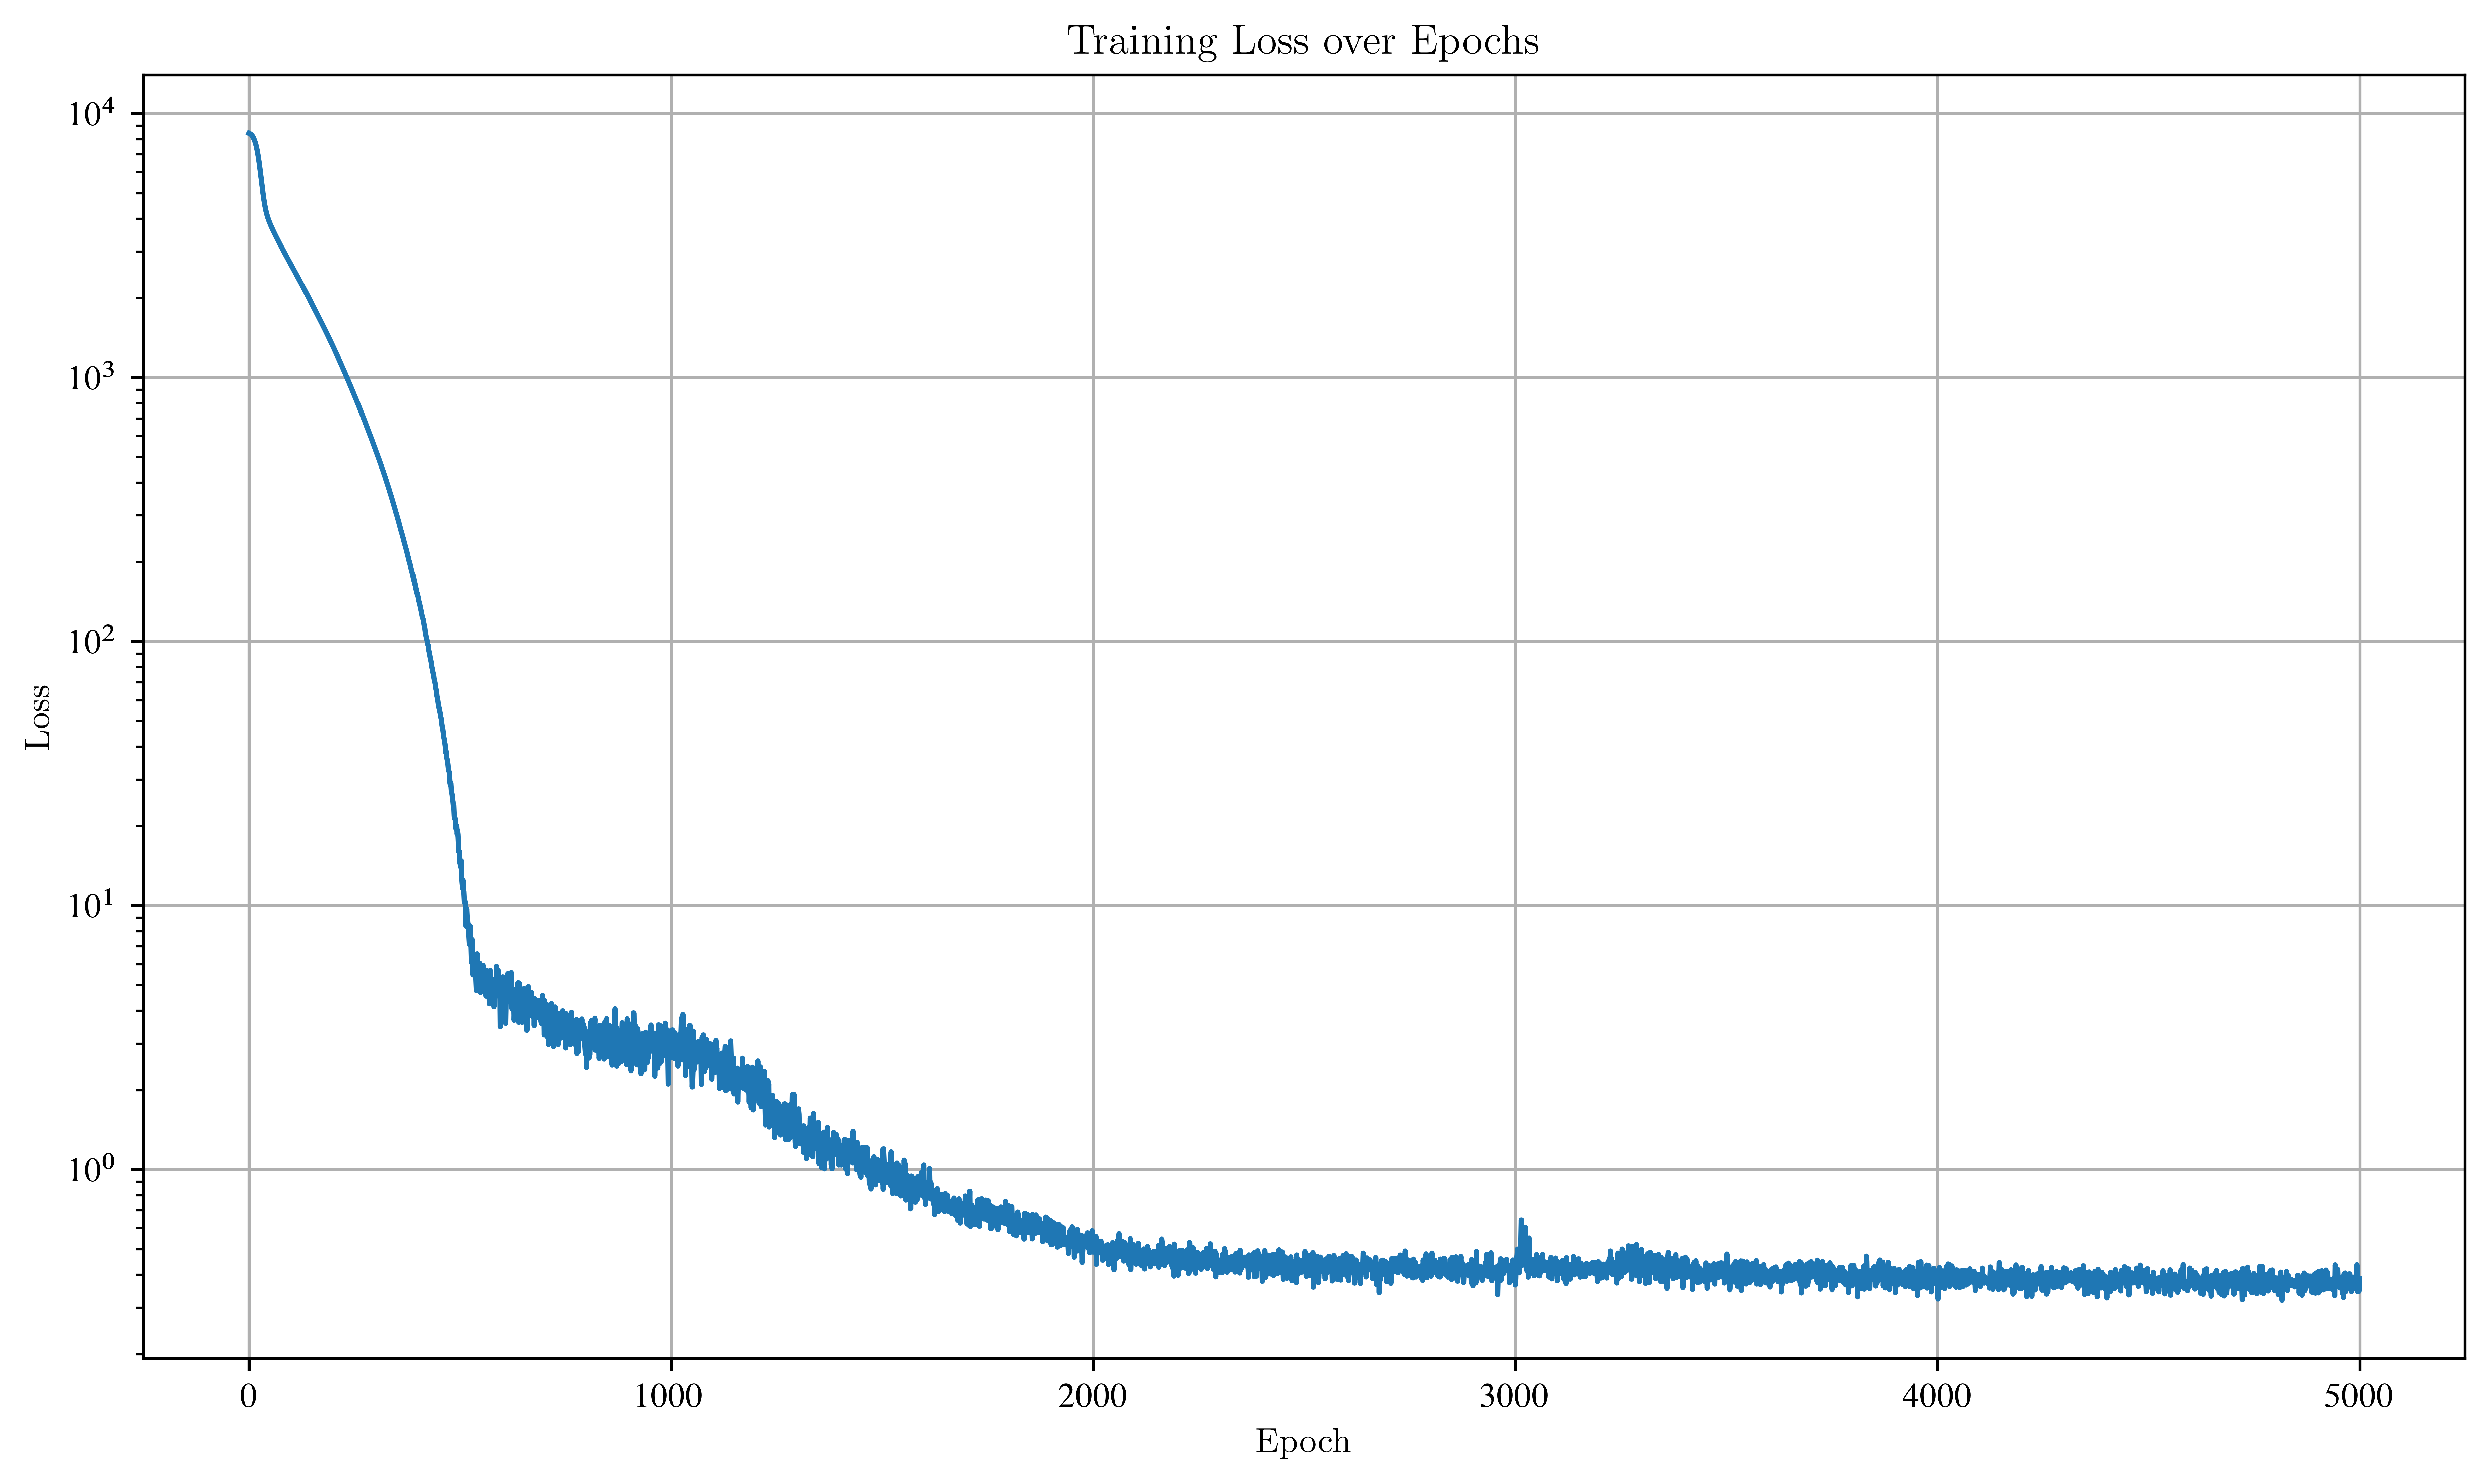

In [7]:
# see solution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.yscale("log")
plt.grid(True)
plt.show()

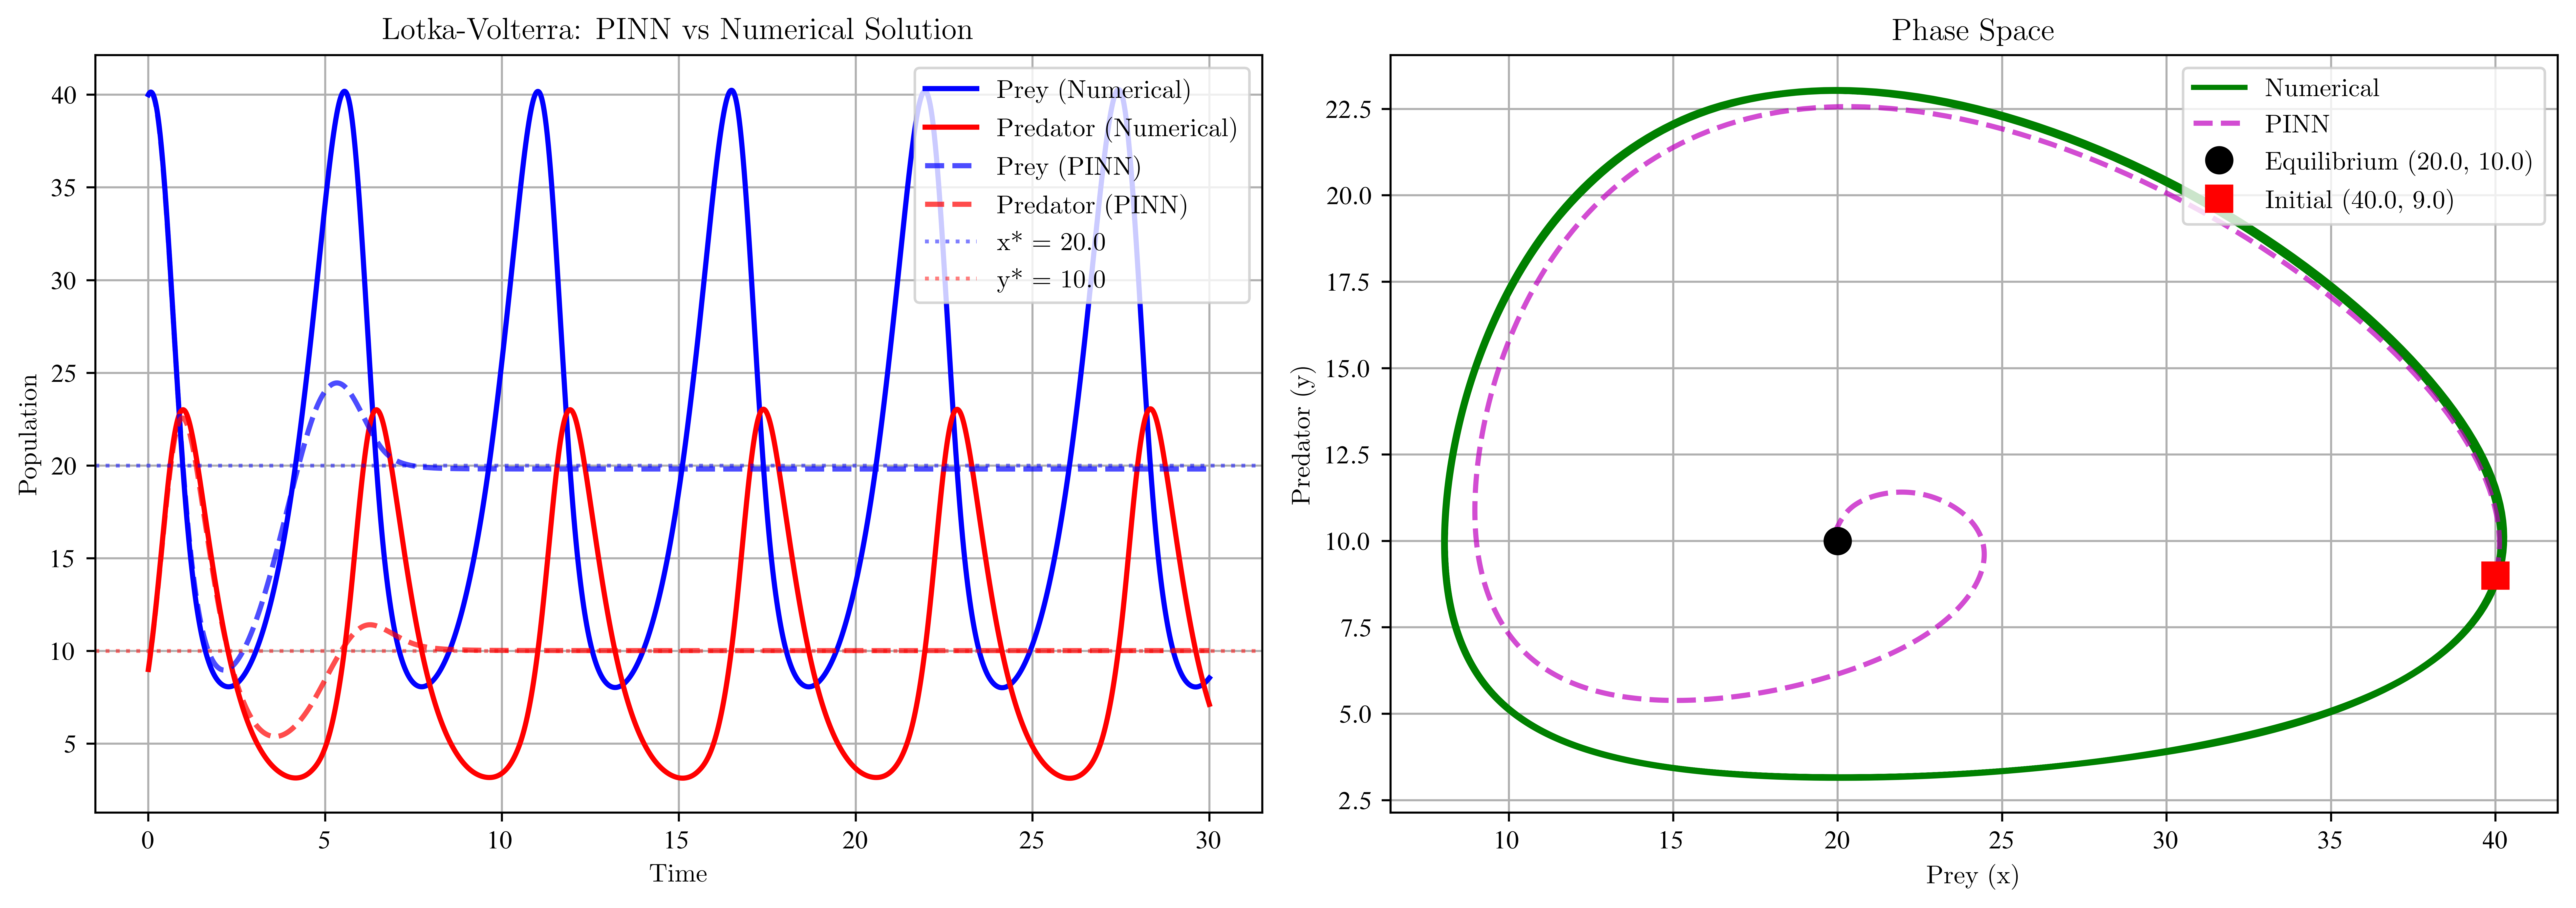


MSE Prey: 102.101862
MSE Predator: 37.963425
Total MSE: 140.065287


In [8]:
# Plot model solution and compare with numerical solution
from scipy.integrate import solve_ivp


def lotka_volterra(t, y, alpha, beta, gamma, delta):
    """Lotka-Volterra ODE system for solve_ivp."""
    x, y_pop = y
    dxdt = alpha * x - beta * x * y_pop
    dydt = delta * x * y_pop - gamma * y_pop
    return [dxdt, dydt]


# Numerical solution using solve_ivp (more modern than odeint)
t_eval = np.linspace(0, tMax, 2000)
y0 = [40.0, 9.0]  # Initial conditions matching the PINN
sol = solve_ivp(
    lotka_volterra,
    [0, tMax],
    y0,
    args=(alpha, beta, gamma, delta),
    t_eval=t_eval,
    method="RK45",
)

# PINN prediction
t_tensor = torch.FloatTensor(t_eval[:, None]).to(device)
with torch.no_grad():
    xy_pred = model(t_tensor).cpu().numpy()
x_pred = xy_pred[:, 0]
y_pred = xy_pred[:, 1]

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series plot
axes[0].plot(sol.t, sol.y[0], "b-", label="Prey (Numerical)", linewidth=2)
axes[0].plot(sol.t, sol.y[1], "r-", label="Predator (Numerical)", linewidth=2)
axes[0].plot(t_eval, x_pred, "b--", label="Prey (PINN)", linewidth=2, alpha=0.7)
axes[0].plot(t_eval, y_pred, "r--", label="Predator (PINN)", linewidth=2, alpha=0.7)
axes[0].axhline(
    y=gamma / delta,
    color="b",
    linestyle=":",
    alpha=0.5,
    label=f"x* = {gamma / delta:.1f}",
)
axes[0].axhline(
    y=alpha / beta,
    color="r",
    linestyle=":",
    alpha=0.5,
    label=f"y* = {alpha / beta:.1f}",
)
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Population")
axes[0].set_title("Lotka-Volterra: PINN vs Numerical Solution")
axes[0].legend(loc="upper right")
axes[0].grid(True)

# Phase space plot
axes[1].plot(sol.y[0], sol.y[1], "g-", label="Numerical", linewidth=2)
axes[1].plot(x_pred, y_pred, "m--", label="PINN", linewidth=2, alpha=0.7)
axes[1].plot(
    gamma / delta,
    alpha / beta,
    "ko",
    markersize=10,
    label=f"Equilibrium ({gamma / delta:.1f}, {alpha / beta:.1f})",
)
axes[1].plot(y0[0], y0[1], "rs", markersize=10, label=f"Initial ({y0[0]}, {y0[1]})")
axes[1].set_xlabel("Prey (x)")
axes[1].set_ylabel("Predator (y)")
axes[1].set_title("Phase Space")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Print error metrics
mse_x = np.mean((x_pred - sol.y[0]) ** 2)
mse_y = np.mean((y_pred - sol.y[1]) ** 2)
print(f"\nMSE Prey: {mse_x:.6f}")
print(f"MSE Predator: {mse_y:.6f}")
print(f"Total MSE: {mse_x + mse_y:.6f}")